# 1. Stylization

### Importing modules to load, transform the image, and send prediction requests to the API

In [2]:
import cv2
import requests
import numpy as np
import matplotlib.pyplot as plt

### Global Variables

In [3]:
MODEL_IMAGE_SHAPE = (256, 256, 3)
PREDICTION_ENDPOINT_STYLE = 'http://localhost:8501/v1/models/stylization:predict'

### Helper functions

In [19]:
def read_image_from_url(url:str) -> np.ndarray:
    """
    Reads an image from a URL
    and returns it as an OpenCV BGR image

    Args:
        url (str) : url of the image

    Returns:
       np.ndarray: A cv2 COLOR image, BGR
    """
    # the user agent header is there to make wikipedia think the request occured from an iphone, it'll forbid the request otherwise
    # you can set this to any human-used browser btw
    response = requests.get(url, headers={
        "User-Agent":"Mozilla/5.0 (iPad; U; CPU OS 3_2_1 like Mac OS X; en-us) AppleWebKit/531.21.10 (KHTML, like Gecko) Mobile/7B405"
    })
    img = cv2.imdecode(np.frombuffer(response.content, np.uint8), cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    return img

def preprocess_style_image(image:np.ndarray, KERNEL_SIZE=(7,7)) -> np.ndarray:
    """
    A simple blur applied to the style image as a preprocessing step,
    also resizes the image to the model's input shape

    Args:
        image (np.ndarray) : A cv2 COLOR image, BGR
        KERNEL_SIZE (tuple) : The kernel size of the average pooling operation

    Returns:
       np.ndarray: A cv2 COLOR image, BGR
    """
    
    kernel = np.ones(KERNEL_SIZE, np.float32)/(KERNEL_SIZE[0]*KERNEL_SIZE[1])
    dst = cv2.filter2D(image,-1,kernel)
    
    # since the model expects a square image, let's try not to distort the image by resizing a non square image to a square one directly
    # and crop it insted, some features will be lost, but the assumption is that the style remains consistent throughout the image, so a
    # little cropping won't make a difference
    
    smallest_dimenstion = min(image.shape[:2])
    squared = dst[:smallest_dimenstion, :smallest_dimenstion]
    final_image = cv2.resize(squared, MODEL_IMAGE_SHAPE[:2])
    return final_image


def convert_to_float(image:np.ndarray)->np.ndarray:
    """
    Converts the uint8 image to float32 image compatible with the model's input
    Args:
        image (np.ndarray) : A cv2 COLOR image, BGR, uint8

    Returns:
       np.ndarray: A cv2 COLOR image, BGR, float32
    """
    image_final = image.astype(np.float32)/255.0
    return image_final


#### Loading and preprocessing our images 

In [20]:
ref_image_url = 'https://upload.wikimedia.org/wikipedia/commons/thumb/0/0d/Black_Snub-nosed_Monkey_(44489823001).jpg/1200px-Black_Snub-nosed_Monkey_(44489823001).jpg'
style_image_url = 'https://upload.wikimedia.org/wikipedia/commons/thumb/d/dc/Abraham_Teniers_-_Barbershop_with_monkeys_and_cats.jpg/1024px-Abraham_Teniers_-_Barbershop_with_monkeys_and_cats.jpg'

ref_image = read_image_from_url(ref_image_url)
style_image = read_image_from_url(style_image_url)
final_ref_image = convert_to_float(ref_image)
preprocessed_style_image = preprocess_style_image(style_image)
final_style_image = convert_to_float(preprocess_style_image(preprocessed_style_image))

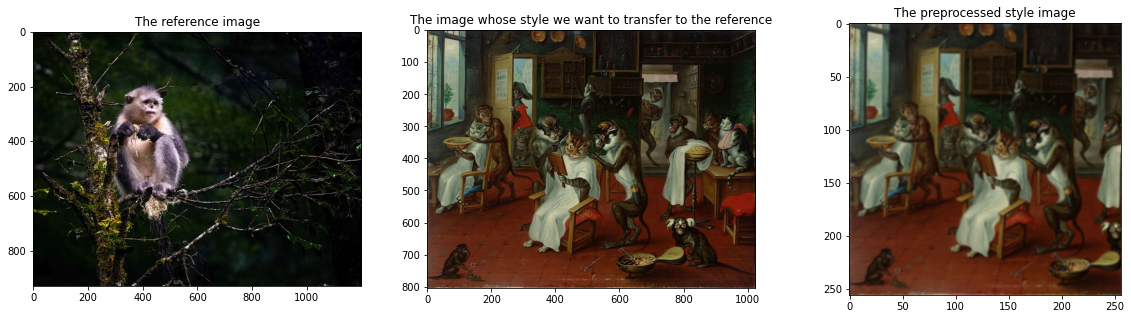

In [21]:
fig, axs = plt.subplots(1, 3, figsize=(20, 5))
axs[0].imshow(ref_image)
axs[0].set_title('The reference image')

axs[1].imshow(style_image)
axs[1].set_title('The image whose style we want to transfer to the reference')

axs[2].imshow(preprocessed_style_image)
axs[2].set_title('The preprocessed style image')
plt.show()

### Transferring the style via our API

In [23]:
resp = requests.post(PREDICTION_ENDPOINT_STYLE, json={
    "instances":[
        {
           "placeholder": final_ref_image.tolist(),
           "placeholder_1": final_style_image.tolist()
        }
    ]
})

# In this particular model, the output image is in the [0] index of the prediction
output_img = np.array(resp.json()['predictions'][0])

### Moment of Truth! Let's see how the style transfer worked!

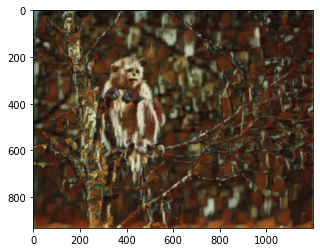

In [24]:
plt.imshow(output_img)
plt.show()